In [8]:
# Import libraries.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning) 

In [9]:
# Import data files from Kaggle.
DATA_PATH = './data/extracted'
dfs_raw = {}
dfs = {}
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        dfs_raw[file.split('.')[0]] = pd.read_csv(f'{DATA_PATH}/{file}')
        dfs = dfs_raw.copy()
        print(file)

age_gender_bkts.csv
train_users_2.csv
countries.csv
sample_submission_NDF.csv
sessions.csv
test_users.csv


In [10]:
# Split training dataset into data and labels.
train_data_all = dfs["train_users_2"]
train_labels_all = dfs["train_users_2"].iloc[:, -1:]

# Evaluate existing representation of classes.
print(pd.value_counts(train_labels_all['country_destination']))
countries = train_labels_all['country_destination'].unique()

# Create pd for each country.
train_data_country = {}
train_labels_country = {}
min_count = -1
for country in countries:
    train_data_country[country] = train_data_all.loc[train_labels_all['country_destination'] == country]
    train_labels_country[country] = train_labels_all.loc[train_labels_all['country_destination'] == country]
    count = train_labels_country[country].shape[0]
    if (min_count == -1 or count < min_count):
        min_count = count

# Create balanced training dataset.
balanced_train_data = pd.DataFrame(columns=train_data_all.columns.values)
for country in countries:
    country_pd = train_data_country[country].sample(n=min_count, random_state=1)
    balanced_train_data = pd.concat([balanced_train_data, country_pd])

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64


In [11]:
# Split into data and labels (panda dataframes).
#reduced this to 10k / 213k since it was taking forever to even test anything
#train_data   = dfs["train_users_2"][:10000].iloc[:, 0:-1] #we should randomize since accounts are in chronological order
#train_labels = dfs["train_users_2"][:10000]["country_destination"].ravel()

# Set train/dev split to 0.04685/0.95315 to give train size of 10k.  0.04685 = 10000/213451
test_size = 0.95315

# Use (train_test_split) to randomize train_users_2 before splitting into train/dev.
train_data, dev_data, train_labels, dev_labels = train_test_split(dfs["train_users_2"].iloc[:, 0:-1], dfs["train_users_2"].iloc[:, -1:], test_size=test_size, random_state=42)

# Final test data for Kaggle submission.
test_data = dfs["test_users"]

In [12]:
#Function to bucket ages prior to one-hot encoding
def age_bucketer(df_input):
    df = df_input
    df.loc[(pd.isnull(df.age), 'age_bucket')] = 'unknown'
    df.loc[(pd.notnull(df.age), 'age_bucket')] = pd.cut(df['age'],
                                                        [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94,99,10000],
                                                        labels=['0-4', '5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
                                                                '50-54', '55-59','60-64', '65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+'],
                                                        include_lowest=True)
    return df.drop(['age'], axis=1)

#Since NaN's in categorical data will cause issues with our pipeline we will replace that with "unknown".
def clean_first_affiliate_tracked_nulls(df_input):
    df_input['first_affiliate_tracked'] = df_input['first_affiliate_tracked'].fillna("unknown", inplace=False)
    return df_input

#Add month and year features
def feature_creator (df_input):
    df = df_input
    df['first_active_date'] = pd.to_datetime(df.timestamp_first_active,format='%Y%m%d%H%M%S')
    df['year_first_active'] = df['first_active_date'].dt.year
    df['month_first_active'] = df['first_active_date'].dt.month
    df['season'] = ''
    df.loc[(df['month_first_active'].isin([12, 1, 2]), 'season')] = 'Winter'
    df.loc[(df['month_first_active'].isin([3, 4, 5]), 'season')] = 'Spring'
    df.loc[(df['month_first_active'].isin([6, 7, 8]), 'season')] = 'Summer'
    df.loc[(df['month_first_active'].isin([9, 10, 11]), 'season')] = 'Fall'
    return df.drop(['first_active_date'], axis=1) #consider dropping month as well

def session_feature_creator(df_input):
    df = df_input
    session_agg = dfs['sessions'].groupby('user_id').agg({"secs_elapsed": np.sum, "device_type": pd.Series.nunique, 'action': 'count'}).reset_index(
        ).rename(columns={'secs_elapsed':'total_time', 'device_type':'unique_device_types', 'action': 'unique_actions'})
    return df.merge(session_agg, left_on='id', right_on='user_id', how='left')

In [13]:
# Create Preprocessor pipeline.
def create_preprocessor_pipeline():

    column_transformer = make_column_transformer(
        (['gender',
          'signup_method',
          'signup_flow',
          'language',
          'affiliate_channel',
          'affiliate_provider',
          'first_affiliate_tracked',
          'signup_app',
          'first_device_type',
          'first_browser',
          'age_bucket',
          'season'
         ], OneHotEncoder(handle_unknown='ignore')),remainder='drop') # when we add in sessions features we will want to pass remainders
    
    preprocessor = make_pipeline(
        FunctionTransformer(age_bucketer, validate=False),
        FunctionTransformer(feature_creator, validate=False),
        FunctionTransformer(clean_first_affiliate_tracked_nulls, validate=False),
        column_transformer)
    
    return preprocessor

In [14]:
# Stage: Data Preprocessor.
preprocessor = create_preprocessor_pipeline()

In [15]:
balanced_data = balanced_train_data.iloc[:, 0:-1]
balanced_labels = balanced_train_data.iloc[:,-1:]

## Model Selection Methodology And Analysis

In order to generate predictions of destination countries, we examined a variety of machine learning algorithms.  In this next section, we will examine the efficacy of k-neighbors, Bernoulli Naive Bayes, Random Forest, Logistic Regression, and XGBoost.  While we will go into detail on each specific model, these models were selected due to their efficacy at solving customer purchase prediction problems or their efficacy at classifying imbalanced classes in available research and literature.  Given that our task is ultimately predicting customer behavior in an environment in which two choices are selected much more frequently than all others, we believe these choices to be appropriate for our use case.  Ultimately, inspired by both previous winners of this competition as well as additional research, we will combine our most effective and practical (evaluated by runtime) models into an ensemble voting classifier to generate the most robust predictions possible.

Throughout our process, we will compare accuracy scores and class-level F1 scores while optimizing our models to the optimal parameters for both "Weighted F1" scores and "Macro F1" scores.  Optimizing for "Weighted F1" scores will tune our models to a weighted average F1 score across all classes.  Given that our data contains significantly more examples of the "NDF" and "US" classes, the F1 scores for those two classes will largely dictate which parameters are deemed optimal.  Optimizing for "Macro F1" will maximize a non-weighted F1 score, meaning that the F1 score for each class is treated equally.  This typically results in uncommon classes being predicted more frequently, often at the expense of overall accuracy.

Due to the size of our dataset, we will most often be using a 10,000 record random sample from the training data for training, while testing on a much larger "development" set consisting of the remainder of the training set.  While we would prefer to use the full dataset in most cases, the full dataset made fitting several of our models nearly impossible.  Even when the models would fit appropriately, we saw no accuracy or F1 score gain from the additional training examples.  As a result, we feel comfortable that the sample is large enough and representative of our exhaustive dataset.  At times, we will train with a "balanced" training set consisting of an undersampled dataset with equal number of records for each class.  While this often significantly lowers the accuracy of each model, it does provide a helpful point of comparison.

Before creating any models, we will first establish a "baseline" accuracy score and classification report.  To do this, we will simply predict every record's label as "NDF", our most common class.  This will help us establish if our models are truly performing better than a simple "guess".

In [16]:
score_dict = {}

In [17]:
dev_pred = dev_labels.copy()
dev_pred['country_destination'] = 'NDF'
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Baseline'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy:  0.5832952406230493


/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00         0
          CA       0.00      0.00      0.00         0
          DE       0.00      0.00      0.00         0
          ES       0.00      0.00      0.00         0
          FR       0.00      0.00      0.00         0
          GB       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
         NDF       1.00      0.58      0.74    203451
          NL       0.00      0.00      0.00         0
          PT       0.00      0.00      0.00         0
          US       0.00      0.00      0.00         0
       other       0.00      0.00      0.00         0

   micro avg       0.58      0.58      0.58    203451
   macro avg       0.08      0.05      0.06    203451
weighted avg       1.00      0.58      0.74    203451



/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


For the next few sections, we will refer to the above accuracy (58.32%) and classification report as our baseline.

### K-Neighbors Classifier

To begin, we start with a k-neighbors classifier.  In their paper *KNN Approach to Unbalanced Data Distributions*, Zhang and Mani demonstrate the effectiveness of a k-neighbors classifier at learning and accurately predicting minority classes without reducing the ability to predict common clases<sup>[13]</sup>.  Zhang and Mati also discuss the downsides of using other types of classifiers, particularly decision tree classifiers, when classes are heavily imbalanced. We test our model using 1, 3, 5, and 7 neighbors to see which is most effective.

#### Weighted F1 Optimization:

In [18]:
params={'n_neighbors':[1,3,5,7], 'weights':['distance']}
knn = KNeighborsClassifier(n_jobs=-1)
knn_gs = GridSearchCV(knn, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, knn_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['KNN F1 Weighted'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.5705599874171177
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       249
          CA       0.01      0.01      0.01       780
          DE       0.00      0.01      0.01       441
          ES       0.01      0.01      0.01      1127
          FR       0.01      0.03      0.02      1888
          GB       0.01      0.02      0.01       983
          IT       0.01      0.02      0.01       991
         NDF       0.82      0.64      0.72    151934
          NL       0.00      0.00      0.00        73
          PT       0.00      0.00      0.00         7
          US       0.30      0.42      0.35     42554
       other       0.02      0.06      0.03      2424

   micro avg       0.57      0.57      0.57    203451
   macro avg       0.10      0.10      0.10    203451
weighted avg       0.68      0.57      0.61    203451



In [19]:
knn_gs.best_params_

{'n_neighbors': 7, 'weights': 'distance'}

#### Macro F1 Optimized:

In [20]:
params={'n_neighbors':[1,3,5,7], 'weights':['distance']}
knn = KNeighborsClassifier(n_jobs=-1)
knn_gs = GridSearchCV(knn, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, knn_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['KNN F1 Macro'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy:  0.5246767034814279
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       733
          CA       0.01      0.01      0.01      1820
          DE       0.01      0.01      0.01      1682
          ES       0.02      0.01      0.01      2752
          FR       0.04      0.03      0.03      5885
          GB       0.02      0.02      0.02      2381
          IT       0.02      0.01      0.02      4247
         NDF       0.75      0.65      0.69    136099
          NL       0.00      0.01      0.00       111
          PT       0.00      0.00      0.00        33
          US       0.30      0.40      0.34     44521
       other       0.02      0.06      0.03      3187

   micro avg       0.52      0.52      0.52    203451
   macro avg       0.10      0.10      0.10    203451
weighted avg       0.57      0.52      0.54    203451



In [21]:
knn_gs.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

The model's performance, as well as the optimum number of neighbors, varies with both scoring method.  The weighted F1 optimized model has a higher accuracy of 57.06% as opposed to the macro F1 optimized score of 52.47%, but at the cost of lower precision and recall for minority classes.  However, in both cases, the accuracy scores and weighted F1 scores are below the baseline.  In addition, the weighted F1 optimized model performs best when trained with 7 neighbors, while the macro F1 optimized model performs best with only three neighbors.  This makes intuitive sense: given the imbalance in the data, the inclusion of more neighbors makes the model more likely to predict the common "NDF" and "US" classes, while fewer neighbors results in a higher likelihood of predicting uncommon classes.  Regardless, the F1 scores for minority classes are still low even when optimizing around macro F1 scores.  In an attempt to improve F1 for minority classes, we will train the models again, this time using the balanced dataset while optimizing for macro F1.

#### Balanced Dataset F1 Macro Optimized

In [22]:
params={'n_neighbors':[1,3,5,7], 'weights':['distance']}
knn = KNeighborsClassifier(n_jobs=-1)
knn_gs = GridSearchCV(knn, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, knn_gs)
pipeline.fit(balanced_data, balanced_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['KNN Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.13098977149289018
              precision    recall  f1-score   support

          AU       0.49      0.01      0.02     30566
          CA       0.23      0.02      0.03     20785
          DE       0.27      0.02      0.03     15151
          ES       0.17      0.02      0.04     17593
          FR       0.12      0.03      0.05     17747
          GB       0.16      0.02      0.04     16653
          IT       0.13      0.03      0.05     12338
         NDF       0.16      0.75      0.26     24889
          NL       0.26      0.02      0.03     12000
          PT       0.72      0.01      0.03     10144
          US       0.07      0.30      0.12     14740
       other       0.07      0.06      0.07     10845

   micro avg       0.13      0.13      0.13    203451
   macro avg       0.24      0.11      0.06    203451
weighted avg       0.24      0.13      0.07    203451



In [23]:
knn_gs.best_params_

{'n_neighbors': 7, 'weights': 'distance'}

While this does significantly improve precision for a number of minority classes, recall is largely unchanged resulting in only moderate improvements to F1 for uncommon classes, as well as a drop in overall F1.  This model performs significantly worse than the baseline on almost all measures.  We will explore this further in the remaining model training, but this could possibly indicate a lack of feature distinction between the uncommon and common classes, making it difficult for most models to accurately predict the uncommon classes.

In [24]:
#Free some memory
del knn, knn_gs

### Bernoulli Naive Bayes

We will now examine the efficacy of a Bernoulli Naive Bayes model.  Our rationale for choosing this model is do to the quantity of binary features in our post-pipeline dataset.  Given the high number of categorical features, which are one-hot encoded during our pipeline process, we suspect Bernoulli Naive Bayes may perform effectively.  As with KNN, we will examine the efficacy of optimizing the model for both weighted and macro F1 scores, as well as optimizing on the balanced dataset.

#### Weighted F1 Optimized:

In [25]:
params={'alpha': [1.05, .1]}
bnb = BernoulliNB()
bnb_gs = GridSearchCV(bnb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, bnb_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Bernoulli Naive Bayes F1 Weighted'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.5676698566239536
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        16
          CA       0.00      0.05      0.00        22
          DE       0.00      0.00      0.00       144
          ES       0.00      0.01      0.00       147
          FR       0.00      0.02      0.00        58
          GB       0.00      0.00      0.00        83
          IT       0.00      0.03      0.00       152
         NDF       0.67      0.70      0.69    113654
          NL       0.00      0.00      0.00        18
          PT       0.00      0.00      0.00         7
          US       0.60      0.40      0.48     88602
       other       0.00      0.05      0.01       548

   micro avg       0.57      0.57      0.57    203451
   macro avg       0.11      0.10      0.10    203451
weighted avg       0.64      0.57      0.59    203451



In [26]:
bnb_gs.best_params_

{'alpha': 1.05}

#### Macro F1 Optimized:

In [27]:
params={'alpha': [1.05, .1]}
bnb = BernoulliNB()
bnb_gs = GridSearchCV(bnb, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, bnb_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Bernoulli Naive Bayes F1 Macro'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.5685644209170758
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        74
          CA       0.00      0.00      0.00        35
          DE       0.00      0.00      0.00        48
          ES       0.00      0.04      0.00        85
          FR       0.00      0.08      0.00        25
          GB       0.00      0.00      0.00        66
          IT       0.00      0.07      0.01       122
         NDF       0.67      0.70      0.69    113902
          NL       0.00      0.02      0.00        66
          PT       0.00      0.00      0.00        71
          US       0.60      0.40      0.48     88530
       other       0.00      0.06      0.01       427

   micro avg       0.57      0.57      0.57    203451
   macro avg       0.11      0.11      0.10    203451
weighted avg       0.64      0.57      0.59    203451



In [28]:
bnb_gs.best_params_

{'alpha': 0.1}

After tuning the Laplace smoothing parameters (alpha) for the weighted and macro F1 optimized model versions, we see that the macro F1-optimized model performs best under a significantly smaller (0.1) alpha, corresponding to stronger smoothing.  However, in spite of the difference in optimized tuning parameters, both models perform very similarly, with accuracy scores slightly below our baseline.  In comparison to the KNN models, both models show improvement at predicting "US" classes at the expense of predicting "NDF" classes.  Still, both models perform rather poorly when predicting uncommon classes.  Once again, we will examine if balancing the dataset has any effect.

#### Balanced Macro F1 Optimized:

In [29]:
params={'alpha': [1.05, .1]}
bnb = BernoulliNB()
bnb_gs = GridSearchCV(bnb, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, bnb_gs)
pipeline.fit(balanced_data, balanced_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Bernoulli Naive Bayes Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.27802271800089456
              precision    recall  f1-score   support

          AU       0.08      0.00      0.01     11274
          CA       0.09      0.01      0.02      8145
          DE       0.11      0.01      0.02     11096
          ES       0.13      0.02      0.03     17514
          FR       0.14      0.03      0.05     19721
          GB       0.15      0.01      0.03     23456
          IT       0.04      0.02      0.02      7165
         NDF       0.42      0.76      0.54     66450
          NL       0.15      0.01      0.01     15820
          PT       0.06      0.00      0.01      4880
          US       0.06      0.40      0.11      9563
       other       0.05      0.06      0.06      8367

   micro avg       0.28      0.28      0.28    203451
   macro avg       0.12      0.11      0.08    203451
weighted avg       0.21      0.28      0.20    203451



In [30]:
bnb_gs.best_params_

{'alpha': 0.1}

As with KNN, we see a slight improvement in F1 scores for some uncommon classes at the expense of overall F1 scores.  Furthermore, this model experiences a significant drop in prediction accuracy, with the model predicting several uncommon classes with higher frequency than "US" class predictions.  Given that all Naive Bayes models depend on priors derived from the frequency of classes found in the data, balancing the dataset results in significant overprediction of minority classes.  In their paper *Tackling the Poor Assumptions of Naive Bayes Text Classifiers*, Rennie, Shih, Teevan, and Karger state that Naive Bayes classifiers typically perform poorly when there are few training examples due to an inherent bias effect, which is on full display here<sup>[14]</sup>.

## Logistic Regression

Next, we will optimize two logistic regression models: one with class balancing applied and one without.  We will do so while optimizing the regularization parameters, identifying the optimum value of 'C' for both l1 and l2 penalties.  We chose to include logistic regressions due to their widespread use and documented history of success on imbalanced datasets.  In their paper *An experimental comparison of classification algorithms for imbalanced credit scoring data sets*, Brown and Mues show logistic regression performing fairly effectively on imbalanced credit score data, and show additional prior research confirming this finding<sup>[15]</sup>.

#### Class Balanced:

In [31]:
params={'C':[.001,.01, .1, 1, 10, 100, .007], 'penalty':['l1', 'l2']}
lr = LogisticRegression(class_weight = 'balanced', tol=.01)
lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, lr_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Logistic Regression Class Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.5527964964536916
              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      7144
          CA       0.03      0.01      0.02      3861
          DE       0.01      0.00      0.00      1755
          ES       0.03      0.02      0.02      2750
          FR       0.00      0.02      0.00        92
          GB       0.01      0.01      0.01       890
          IT       0.01      0.02      0.01       819
         NDF       0.78      0.69      0.74    134627
          NL       0.03      0.01      0.01      3667
          PT       0.03      0.00      0.00      7473
          US       0.32      0.47      0.38     40287
       other       0.00      0.15      0.00        86

   micro avg       0.55      0.55      0.55    203451
   macro avg       0.11      0.12      0.10    203451
weighted avg       0.59      0.55      0.56    203451



In [32]:
lr_gs.best_params_

{'C': 0.007, 'penalty': 'l2'}

#### No Class Balancing:

In [33]:
params={'C':[.001,.01, .1, 1, 10, 100, .007], 'penalty':['l1', 'l2']}
lr = LogisticRegression(tol=.01)
lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, lr_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Logistic Regression No Class Balancing'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy:  0.6306285051437447


/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00         0
          CA       0.00      0.00      0.00         0
          DE       0.00      0.00      0.00         0
          ES       0.00      0.00      0.00         0
          FR       0.00      0.00      0.00         0
          GB       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
         NDF       0.86      0.68      0.76    150703
          NL       0.00      0.00      0.00         0
          PT       0.00      0.00      0.00         0
          US       0.44      0.49      0.46     52748
       other       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63    203451
   macro avg       0.11      0.10      0.10    203451
weighted avg       0.75      0.63      0.68    203451



/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
lr_gs.best_params_

{'C': 0.1, 'penalty': 'l1'}

While each model optimizes around different penalty and penalty types, the non-class balanced model returns zero predictions for all classes other than "NDF" and "US".  In spite of this, the non-class balanced model offers a further two percentage point accuracy increase over the non-class balanced random forest model, as well as the highest weighted F1 score thus far.

## Random Forst Classifier

While Zhang and Mani identify some of the drawbacks of decision tree classifiers at predicting imblanced classes, Random Forest Classifiers have been shown to be effective at predicting imbalanced classes in some cases.  In *Using Random Forest to Learn Imbalanced Data*, Chen, Liaw, and Breiman describe the usage of "balancing" features, similar to the one found in Scikit-Learn's Random Forest Classifier Package, as being effective with heavily imbalanced classes<sup>[16]</sup>.   As a result, we will optimize two models, one using Scikit-Learn's built-in class balancing feature and one without any additional class balancing.  

#### Class Balanced:

In [35]:
params={'n_estimators':[300], 'max_depth':[5,10,20]}
rf = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced_subsample')
rf_gs = GridSearchCV(rf, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, rf_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Random Forest Class Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.47113555598153856
              precision    recall  f1-score   support

          AU       0.01      0.00      0.00      2454
          CA       0.02      0.01      0.01      5057
          DE       0.01      0.01      0.01      1833
          ES       0.02      0.01      0.01      3801
          FR       0.03      0.03      0.03      4946
          GB       0.02      0.01      0.02      3538
          IT       0.03      0.01      0.02      6791
         NDF       0.61      0.67      0.64    107991
          NL       0.01      0.00      0.01      2957
          PT       0.00      0.00      0.00       980
          US       0.38      0.43      0.40     52986
       other       0.06      0.05      0.06     10117

   micro avg       0.47      0.47      0.47    203451
   macro avg       0.10      0.10      0.10    203451
weighted avg       0.43      0.47      0.45    203451



In [36]:
rf_gs.best_params_

{'max_depth': 20, 'n_estimators': 300}

#### No Class Balancing:

In [37]:
params={'n_estimators':[300], 'max_depth':[5,10,20]}
rf = RandomForestClassifier(n_jobs = -1)
rf_gs = GridSearchCV(rf, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, rf_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Random Forest No Class Balancing'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.6120392625251289
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        36
          CA       0.00      0.03      0.00        58
          DE       0.00      0.03      0.00        33
          ES       0.00      0.02      0.00        57
          FR       0.00      0.04      0.00       212
          GB       0.00      0.01      0.00       103
          IT       0.00      0.02      0.00       116
         NDF       0.84      0.67      0.75    149615
          NL       0.00      0.00      0.00        29
          PT       0.00      0.00      0.00         4
          US       0.41      0.47      0.44     52437
       other       0.00      0.06      0.01       751

   micro avg       0.61      0.61      0.61    203451
   macro avg       0.11      0.11      0.10    203451
weighted avg       0.73      0.61      0.66    203451



In [38]:
rf_gs.best_params_

{'max_depth': 20, 'n_estimators': 300}

As expected, the class-balanced model has slightly higher uncommon class F1 scores than the model without balancing.  However, this comes with a cost of significantly reduced accuracy and weighted F1 scores, well below our baseline.  On the other hand, the non-balanced model returns an accuracy score three percentage points above our baseline.

In [39]:
#free memory
del rf, rf_gs

## XGBoost

For our final model, we will use XGBoost, another tree-based model similar to Random Forest, but with compounding decision trees building off of each other rather than individual trees "voting" for the best prediction.  While our motivation for partly due to the success of this algorithm with other users on Kaggle, we believe XGBoost's natural regularization may offer similar performance to Random Forest.  In their paper *XGBoost: A Scalable Tree Boosting System*, Chen and Guestrin describe the flexibility of the model, as well as its ability to scale quickly to larger datasets<sup>[17]</sup>.  While XGBoost may not prove the most effective model for the purposes of this competition, it may provide a scalable alternative for even larger datasets or a substitute in a production system.  Thus, we think it is worth pursuing. As with some of our previous examples, we will first optimize a model using the full training set before using a balanced class dataset.

#### Full Training Set:

In [40]:
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['XG Boost Full Training Set'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy:  0.6335333815021799


/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00         0
          CA       0.00      0.00      0.00         0
          DE       0.00      0.00      0.00         0
          ES       0.00      0.00      0.00         0
          FR       0.00      0.00      0.00         0
          GB       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
         NDF       0.85      0.69      0.76    146802
          NL       0.00      0.00      0.00         0
          PT       0.00      0.00      0.00         0
          US       0.47      0.49      0.48     56649
       other       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63    203451
   macro avg       0.11      0.10      0.10    203451
weighted avg       0.74      0.63      0.68    203451



/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [41]:
xgb_gs.best_params_

{'booster': 'gbtree'}

#### Balanced Training Dataset:

In [42]:
#params={'reg_lambda':[100]}
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb_gs)
pipeline.fit(balanced_data, balanced_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['XG Boost Balanced Training Set'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

Accuracy:  0.31606627640070584
              precision    recall  f1-score   support

          AU       0.12      0.01      0.01      9385
          CA       0.16      0.01      0.02     16962
          DE       0.12      0.01      0.02     10345
          ES       0.10      0.02      0.03     12986
          FR       0.13      0.04      0.06     16613
          GB       0.09      0.02      0.03     11602
          IT       0.10      0.02      0.03     14100
         NDF       0.47      0.77      0.58     71539
          NL       0.15      0.01      0.02     11281
          PT       0.13      0.00      0.01      6736
          US       0.12      0.43      0.18     16001
       other       0.03      0.06      0.04      5901

   micro avg       0.32      0.32      0.32    203451
   macro avg       0.14      0.12      0.09    203451
weighted avg       0.24      0.32      0.24    203451



In [43]:
xgb_gs.best_params_

{'booster': 'gbtree'}

Similar to logistic regression, the non-class balanced trained model only returns predictions of "NDF" or "US", but does so with a relatively high accuracy score.  The balanced model returns more predictions for the uncommon classes, but at a cost of overall accuracy and F1, similar to our prior examples.

### Ensemble Voting Classifier

Thus far, our models have returned similar results with varying levels of efficacy.  In all cases, balancing classes results in more predictions of uncommon classes, to the detriment of overall accuracy and weighted F1 scores. In fact, the two classifiers with the highest accuracy both predict no instances of uncommon classes.  We suspect this is due to examples of uncommon classes having similar feature values to the more common classes.  Our models are able to parse between likely "NDF" and non-"NDF" examples, but are unable to accurately predict any non-"NDF" classes outside of "US".

In a final attempt to improve our predictions, we will try combining classifiers through a "Voting Classifier".  This classifier will utilize predictions from multiple individual classifiers to pick a single prediction for each instance.  When set to "hard" voting each classifier has a single vote, while setting the voting to "soft" will generate predictions based on weighted averages derived from the strength(probability) of the prediction from each individual model.

In [44]:
# Train

bnb = BernoulliNB(alpha=1.05)
rf = RandomForestClassifier(n_jobs = -1, n_estimators=300, max_depth=10, class_weight='balanced')
lr = LogisticRegression()
xgb = XGBClassifier(n_jobs=-1)

vc = VotingClassifier(estimators = [('bnb', bnb),
                                    ('rf', rf),
                                    ('lr', lr),
                                    ('xgb', xgb)], voting='hard')

pipeline = make_pipeline(preprocessor, vc)

In [45]:
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Voting Classifier'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy:  0.6306481658974397


/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00         5
          CA       0.00      0.14      0.00         7
          DE       0.00      0.00      0.00         6
          ES       0.00      0.01      0.00        94
          FR       0.00      0.14      0.00         7
          GB       0.00      0.00      0.00        28
          IT       0.00      0.00      0.00        25
         NDF       0.86      0.68      0.76    150215
          NL       0.00      0.00      0.00         1
          PT       0.00      0.00      0.00         0
          US       0.44      0.49      0.46     53038
       other       0.00      0.08      0.00        25

   micro avg       0.63      0.63      0.63    203451
   macro avg       0.11      0.13      0.10    203451
weighted avg       0.75      0.63      0.68    203451



/home/cventura/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


After testing a variety of parameters, we eventually exclude the KNN model as it reduced both F1 and accuracy scores.  Our voting classifier model returns similar accuracy and weighted F1 scores to our top performing individual models, but with a handful of predictions for uncommon classes.  This indicates that our models are likely "learning" similar patterns.  Given that no improvement is gained through combining models, our models are returning the same predictions for the vast majority of instances.  As a result, we believe that additional features are needed for additional improvement.

## Conclusion

In the previous sections, we analyzed Airbnb user data and trained several machine learning classifiers in order to predict the user's first destination country. To compare the performance of each model, we graph the model accuracies and weighted F1 scores below:

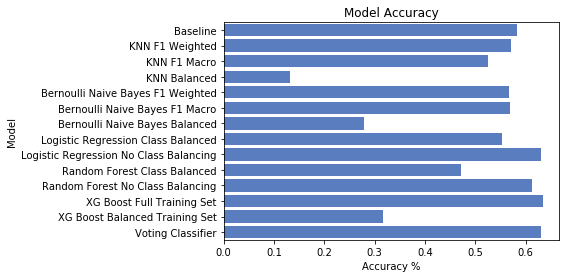

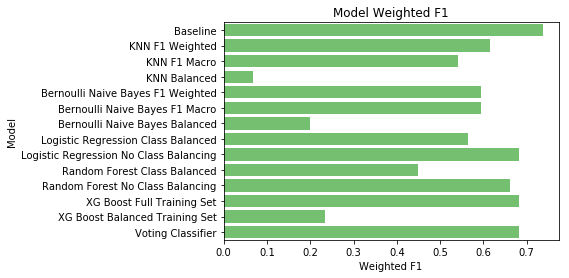

In [46]:
score_df = pd.DataFrame(
    {'Model': list(score_dict.keys()),
     'Accuracy': [item[0] for item in list(score_dict.values())],
     'Weighted F1': [item[1] for item in list(score_dict.values())]    
    }
)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Model', data=score_df, color="b")

plt.xlabel('Accuracy %')
plt.title('Model Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Weighted F1', y='Model', data=score_df, color="g")

plt.xlabel('Weighted F1')
plt.title('Model Weighted F1')
plt.show()

As shown in the accuracy and F1 comparisons above, only a handful of the models offer improvement over the baseline.  Given that the Voting Classifier offers no improvement over the individual Logistic Regression and XGBoost models, we would favor either of those options over the Voting Classifier simply due to the simplicity.  While both Logistic Regression and XGBoost offer similar performance, we favor XGBoost due to its slight edge in accuracy and ability to scale.  Given the descriptions Chen and Guestrin describe in their paper, we believe the XGBoost model is likely to improve the most with additional data and features, and thus believe it is a valid choice for our final model.  Our recommendation would therefore be to utilize our upfront preprocessing pipeline along with an XGBoost model trained on a dataset without class balancing applied.

While our model is more effective than the baseline, we believe significant improvement could be gained from additional features.  The datasets provided by Kaggle included only demographic and user session data, but both types of datasets were fairly limited.  We ultimately discarded the sessions data after it provided no measurable improvement to our models at the cost of increased training time.  This is because the sessions data only contained high-level action descriptions, such as actions consisting of a user search without specifying for what the user searched.  If more detailed demographic information or more specific user actions such as search destinations were provided, we believe the models could be significantly improved.

Under our recommended model, we managed to improved the accuracy over our baseline by five percentage points, highlighting the power of machine learning on even relatively weakly-indicative features.  This process, however, highlights the importance of identifying and capturing useful features that are likely to help answer a desired question.  While we certainly believe our model would be a useful tool to Airbnb, we are almost certain they have developed more robust and accurate models to answer our research question with the features they have at their disposal.

### Submission to Kaggle

For the purposes of answering our research question, we optimized our models to generate the single best prediction for test user.  The Kaggle competition allows for the submission of up to five ranked guesses per each test example, with penalties applied for each additional wrong guess.  This provides another layer of optimization somewhat outside the scope of answering our research question.  As a result, we did not focus on optimizing the scores around generating multiple guesses.

In [47]:
#Implement XGBoost Model
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb_gs)
pipeline.fit(train_data, train_labels.values.ravel())

# Generate predictions for test data to submit to Kaggle for scoring.
predictions = pipeline.predict(test_data)

# Save to csv
final_csv = 'kaggle_submission.csv'
predictions_pd = pd.DataFrame(data=predictions, columns=['country'])
test_result = pd.concat([test_data['id'], predictions_pd], axis=1, sort=False)
test_result.to_csv(final_csv, index=False)
print("WRITTEN: %s" %(final_csv))

WRITTEN: kaggle_submission.csv


Kaggle Score:

<img src="kaggle_score.png" align="center"/>

Even though we did not optimize for multiple predictions, our model managed to beat the baseline Kaggle score of $.68411$.

## References

[1] “Airbnb New User Bookings - Description” Kaggle, 24 Nov. 2015, https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#description.

[2] Molnar, Christoph “Feature Importance” Interpretable Machine Learning, https://christophm.github.io/interpretable-ml-book/feature-importance.html.

[3] Fisher, Rudin, and Dominici “All Models are Wrong but many are Useful: Variable Importance for Black-Box, Proprietary, or Misspecified Prediction Models, using Model Class Reliance” arXiv, https://arxiv.org/abs/1801.01489v3.

[4] “Airbnb New User Bookings - Evaluation” Kaggle, 24 Nov. 2015, https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#evaluation.

[5]  Smolyakov, Vadim. “Ensemble Learning to Improve Machine Learning Results.” <i>Stats and Bots</i>, 22 Aug. 2017, blog.statsbot.co/ensemble-learning-d1dcd548e936.

[6]  Zinkevich, M. 2017. Rules of Machine Learning: Best Practices for ML Engineering.  http://martin.zinkevich.org/rules_of_ml/rules_of_ml.pdf.

[7]  “Airbnb New User Bookings, Winner's Interview: 2nd Place, Keiichi Kuroyanagi (@Keiku).” <i>No Free Hunch</i>, 15 Mar. 2016, blog.kaggle.com/2016/03/17/airbnb-new-user-bookings-winners-interview-2nd-place-keiichi-kuroyanagi-keiku/.

[8]  Shekhar, Amit. “What Is Feature Engineering for Machine Learning? – MindOrks – Medium.” <i>Medium.com</i>, Medium, 14 Feb. 2018, medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a.

[9]  “Airbnb New User Bookings, Winners Interview: 3rd Place: Sandro Vega Pons.” <i>No Free Hunch</i>, 15 Mar. 2016, blog.kaggle.com/2016/03/07/airbnb-new-user-bookings-winners-interview-3rd-place-sandro-vega-pons/.

[10]  Kumar, Ajitesh. “Machine Learning: Validation Techniques - DZone AI.” <i>Dzone.com</i>, 12 Feb. 2018, dzone.com/articles/machine-learning-validation-techniques.

[11]  Brownlee, Jason. “Data Leakage in Machine Learning.” <i>Machine Learning Mastery</i>, 31 July 2018, machinelearningmastery.com/data-leakage-machine-learning/.

[12]  Brownlee, Jason. “A Gentle Introduction to XGBoost for Applied Machine Learning.” <i>Machine Learning Mastery</i>, 21 Sept. 2016, machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/.

[13] Zhang and Mani. “kNN Approach to Unbalanced Data Distributions” Georgetown University, Aug 2003, https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf

[14] Rennie, Shih, Teevan, and Karger. “Tackling the Poor Assumptions of Naive Bayes Text Classifiers” MIT, Aug 24 2003, https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

[15] Brown and Mues. “An experimental comparison of classification algorithms for imbalanced credit scoring data sets" University of Southampton, Sep 8 2011, https://ac.els-cdn.com/S095741741101342X/1-s2.0-S095741741101342X-main.pdf?_tid=3b8964bd-0bd4-4dc4-be77-42d9a8e2e84e&acdnat=1544577102_68a1229f0d71032b4796e9feb64cb601

[16] Chen, Liaw, and Breiman. “Using Random Forest to Learn Imbalanced Data" University of California, Berkeley, July 2004, https://statistics.berkeley.edu/tech-reports/666

[17] Chen and Guestrin. “XGBoost: A Scalable Tree Boosting System" University of Washington, Seattle, August 17 2016 https://arxiv.org/pdf/1603.02754.pdf